# Bayesian inference and Monte Carlo method: short introduction
#### Edwin Genoud-Prachex
#### genoud@itp.uni-frankfurt.de


v1: 7th February 2023 for EXPLORE III 

**v2 (this version): 6th April 2023 for DMGW group meeting** (differences with v1: few typos corrected + some adjustments + introduction)

## Introduction

We very often hear/read about **Bayesian inference** and about **Monte Carlo algorithms**. In this file, I propose a short introduction to these fascinating topics and show how they are related. 

In *part 1.* I give a reminder of the **Bayes' theorem** in statistics and how to use it in a practical example. *Part 2.* explains **Bayesian inference**, and gives a short mathematical example of inference. Then I talk about Monte Carlo algorithm that are a useful tool to perform Bayesian inference: *part 3.* introduces the basic idea of **Monte Carlo algorithm** (with a computation of $\pi$ in bonus!), while in *part 4.* we see how **Markov chain Monte Carlo (MCMC)** works (in particular the Metropolis–Hastings algo.) and how we can determine if the algorithm has **converged**. *Part 5.* shows another example of MCMC algorithm with the explicite example of the **Python package $\texttt{emcee}$** (that implements a "stretch move" ensemble method) and also how to **read corner plots** that show the outputs of such algorithms. Finally, *part 6.* highlights a few **good scientific practices** that should always be complied when using the software $\texttt{emcee}$ (or another equivalent software).

There are of course many other things to say about these amazing topics! I tried to write this document as easy and pleasant to read as I could, while being rigourous enough. I hope it will be useful for you and that you'll enjoy it!

All comments or propositions of modifications are welcome! Please don't hesitate to ask me if you have any question or if you find anything wrong or ununderstandable!


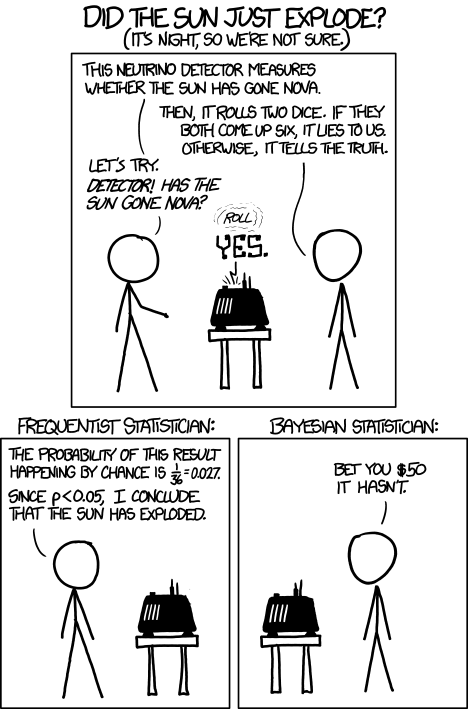

*Fig. 1: XKCD: Frequentists vs. Bayesians (https://xkcd.com/1132/)*

(If you do not understand this comics now, don't worry: read parts 1 and 2 and come back ;-).)

## 1. Bayes formula

In statistics, we work with events $-A-$ and their associated probability $-P(A)$. If we have two events $A$ and $B$ and if $P(A) \neq 0$, we can define $P(B|A)$, the *conditional probability of the event $B$ given the event $A$* by:

\begin{equation}
P(B|A) = \frac{P(A \cap B)}{P(A)} \, . \notag
\end{equation}

This equation gives the probability that the event $B$ occurs after a first try where the event $A$ occurded. 

If $P(B) \neq 0$, then the last equation is symmetric under the transformation $A \leftrightarrow B$:

\begin{equation}
P(A|B) = \frac{P(B \cap A)}{P(B)} \, , \notag
\end{equation}

and since $A \cap B = B \cap A$, we get:

\begin{equation}
P(A|B) = \frac{P(B|A) P(A)}{P(B)} \, . \tag{1}
\end{equation}

Eq. (1) is the *Bayes' formula* (or *theorem*) (Thomas Bayes, 1763). 

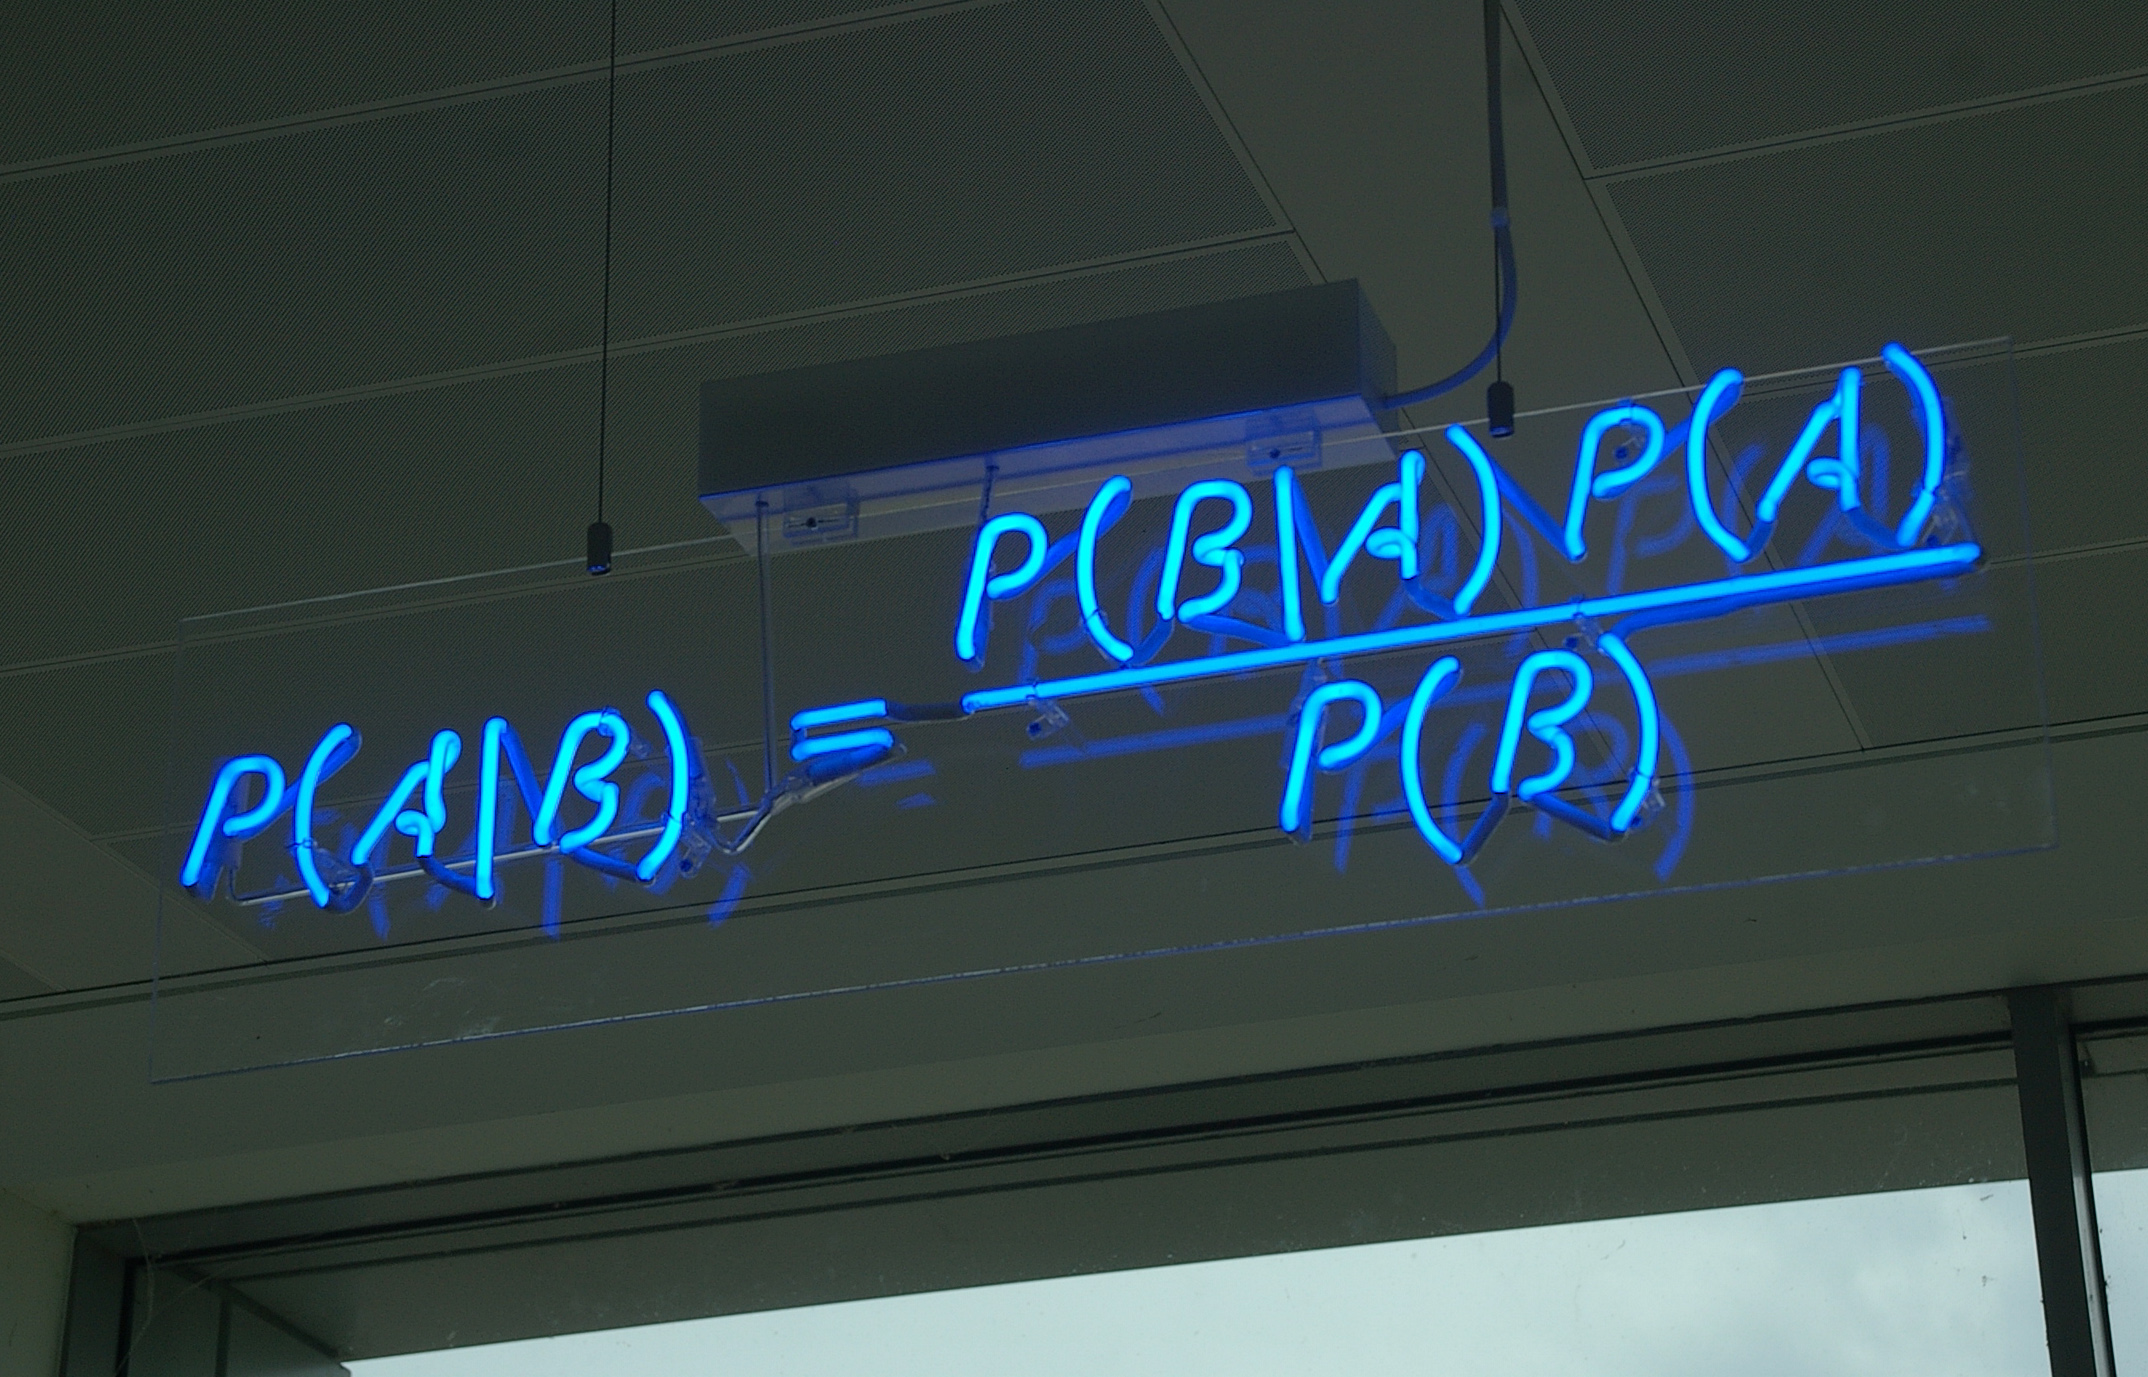 

*Fig. 2: Bayes' theorem spelt out in blue neon at the offices of Autonomy in Cambridge. Picture from Wikimedia.*

**Example 1:** In a given population, one person over one thausand has a disease. A test exists, and is very good: it only has 1% of false positive and 0% of false negative (i.e. if you're sick and you do the test, it will always be postive, while if you're not sick and you do the test, in 1% of the cases it will be positive). 
It is mandatory for everyone to do the test. My test turns positive. Am I sick? Let's use the Bayes' theorem!

I want to know the probability of being sick given the fact that my test is positive. Hence if: $A = \{ \text{being sick} \}$, $\bar{A} = \{ \text{being heathly} \}$  and $B = \{ \text{my test is positive} \}$, we can write eq. (1) as: 

\begin{equation}
P(A|B) = \frac{P(B|A) P(A)}{P(B)} = \frac{P(B|A) P(A)}{P(B|A) P(A) + P(B|\bar{A}) P(\bar{A})} = \frac{1 \cdot 10^{-3}}{1 \cdot 10^{-3} + 10^{-2} \cdot (999/1000)} \approx 0.09 \, . \notag
\end{equation}

I have only 9% of probability of being sick. I must do other tests!

## 2. Bayesian inference 

Now, we want to perform inferences (we want to update our knowledge with information). Let's assume that we have a theory $T$ with free parameters $\theta$. We also know a sample of outputs of the theory (from experiment or observation) $\mathcal{D}$. Our goal is to constrain the value of the free parameters $\theta$, given the data $\mathcal{D}$ we have. Ref. [1] is an amazing course on the topic of Bayesian inference applied to cosmological problems.

We can write the Bayes's theorem, eq. (1), as:

\begin{equation}
P(\theta | \mathcal{D}) = \frac{P(\mathcal{D} | \theta ) P(\theta)}{P(\mathcal{D})} \, . \notag
\end{equation}

Very often, we give different names to the different probability distributions:

\begin{equation}
p(\theta | \mathcal{D}) = \frac{\mathcal{L}(\mathcal{D} | \theta ) \ \pi(\theta)}{\mathcal{Z}(\mathcal{D})} \, , \tag{2}
\end{equation}

- $p(\theta | \mathcal{D})$ is called the **posterior probability**
- $\mathcal{L}(\mathcal{D} | \theta )$ is the **likelihood** 
- $\pi(\theta)$ is the **prior**
- $\mathcal{Z}(\mathcal{D})$ is the **evidence**.

This equation means that we want to find the "probability that a parameter takes a given value", so we want to compute the posterior $p(\theta | \mathcal{D})$.

If we're only interested in the value of given parameters in a given theory, the evidence can be seen as a simple normalisation factor (to insure that $\int p(\theta | \mathcal{D}) \ \text{d}\theta = 1$), so we just need to compute the **likelihood** $\mathcal{L}$ ("the probability to obtain the data given the value of the parameters") and the **prior** $\pi$ ("the a priori knowledge on the the value of the parameters"):

\begin{equation}
p(\theta | \mathcal{D} ) \propto \mathcal{L}(\mathcal{D} | \theta ) \ \pi(\theta) \, ,  \tag{3}
\end{equation}

and we see that Bayesian inference consists in evaluations of functions.

**Example 2:** We have 100 samples (= our data $\mathcal{D}$) of a Gaussian (= the theory $T$). A Gaussian is fully determined by two parameters: its mean $\mu$ and its standard deviation $\sigma$, thus the free parameter is $\theta = \{ \mu, \sigma  \}$. 

For simplicity, let's assume that we know $\sigma$: so we want to constrain the value of $\mu$, i.e. $p(\mu | \mathcal{D} )$. The likelihood gives the probability to have the sample $\mathcal{D}_i$ from a Gaussian with parameters $\theta = \{\mu, \sigma \}$. This is exactly the meaning of the probability distribution function:

$$
\mathcal{L}(\mathcal{D}_i | \theta ) = \frac{1}{\sigma \sqrt{2\pi}} \exp \left \{ - \frac{1}{2} \left (\frac{\mathcal{D}_i - \mu}{\sigma}  \right )^2  \right \} \, . \notag
$$

For the prior on $\mu$, $\pi(\mu)$, let's take a constant prior (i.e. we have no hint on the value of $\mu$).

We now have to test many different values for $\mu$ and see which maximises the posterior $p(\mu | \mathcal{D} )$, see results in fig. 3.

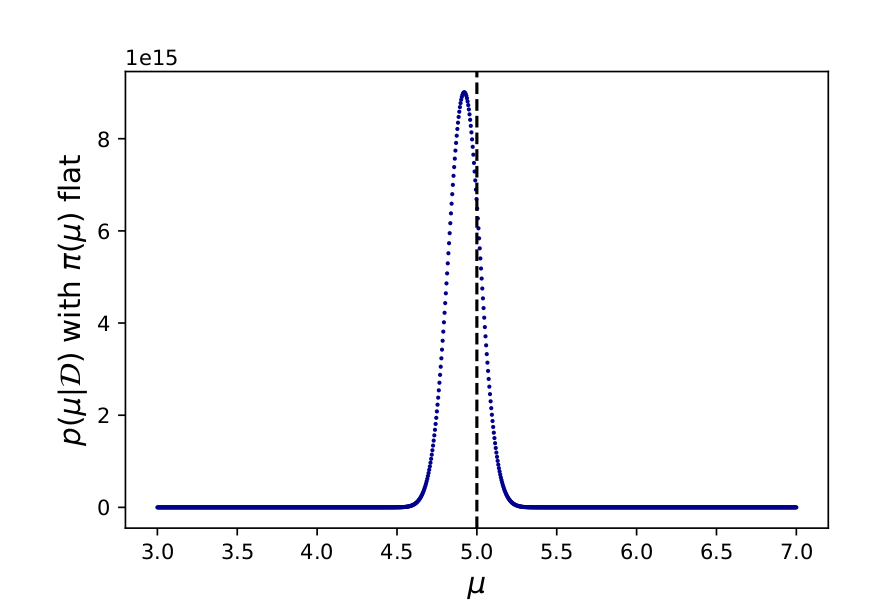

*Fig. 3: (Non normalised) posterior distribution function of $p(\mu|\mathcal{D}, \sigma)$ as a function of $\mu$. The black dashed line corresponds to the fiducial value $\hat{\mu}$ of the parameter (i.e. the value that I've used to generate the data).*

## 3. Monte Carlo method

We've seen that Bayesian infrence consists in evaluation of functions. In the previous example it was possible to compute it analytically. However very often the number of parameters and data don't allow analytical results. We then need numerical evaluation of the functions. 

The Monte Carlo method is a very powerful tool that uses chance to evaluate in a very accurate way an integral. This class of algorithms takes its name from the Monte Carlo Casino. It's funny to note that, according to the English Wikipedia views, Monte Carlo is now more famous for the method than for the Casino! (and same for the French language Wikipedia.)

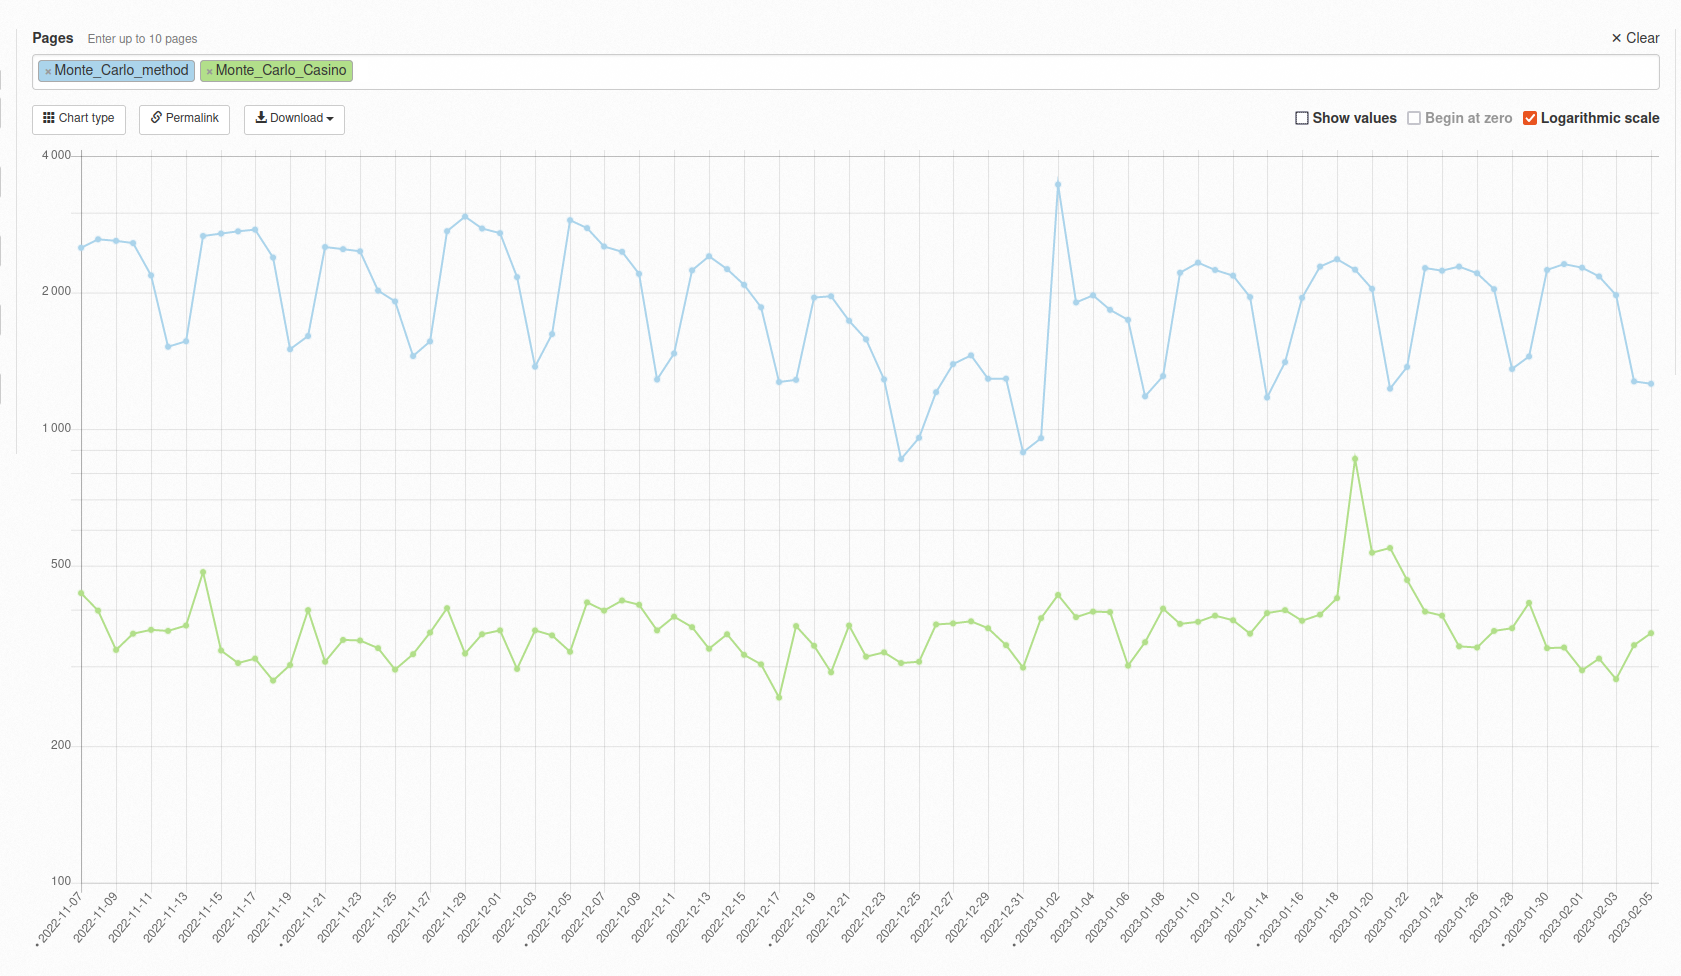

*Fig. 4: Screenshot of Wikipedia's "Pageviews".*

How does it work? See refs [1, 2]

Let $f(x)$ be a function. We want to evaluate its integral $I$:

\begin{equation}
I = \int_a^b f(x) \ \text{d}x = \int_a^b \frac{f(x)}{P(x)} P(x) \ \text{d}x \, , \notag
\end{equation}

with $P$ a (yet undefined) probability distribution function and $P(x) \neq 0$, $\forall x \in [a,b]$. The goal is now to
generate $N$ samples of the function $P(x)$, and to evaluate the function $(f /P)$ on the samples $\{x_i \}_{i=1}^N$, then to take the arithmetic mean of the values:

\begin{equation}
\frac{1}{N} \sum_{i=1}^N \frac{f(x_i)}{P(x_i)} = \left (  \frac{f}{P} \right )_N \, . \notag
\end{equation}

The strong law of large numbers says that this mean converges (almost surely) to the expected value $\mu$:

\begin{equation}
P \left \{  \lim_{N \rightarrow \infty} \left ( \frac{f}{P}  \right )_N = \mu  \right \} = 1 \, , \notag
\end{equation}

where:

\begin{equation}
\mu = \mathbb{E} \left [  \frac{f}{P} \right ] \equiv \int_a^b \frac{f(x)}{P(x)} P(x) \ \text{d}x = \int_a^b f(x) \ \text{d}x = I \, . \notag
\end{equation}

Sometimes, we also see Monte Carlo integration equivalently written as:

\begin{equation}
\int_\mathscr{D} f(x) p(x) \ \text{d}x = \frac{1}{N} \sum_{i=1}^N f(x_i) |_{x_i \sim p(x)} \, , \tag{4}
\end{equation}

where $x_i \sim p(x)$ means that the samples $x_i$ come from the distribution $p(x)$.

**Example 3 (see [3]):** Let's compute the value of $\pi$. We know that the area of the unit disc is $(1/4)\pi$, while the area of a unit square is 1. We can compute the area of the unit disc with a Monte Carlo method by sampling its surface with constant probability:

On 500 samples of the unit square, 390 samples also lie in the unit disc.


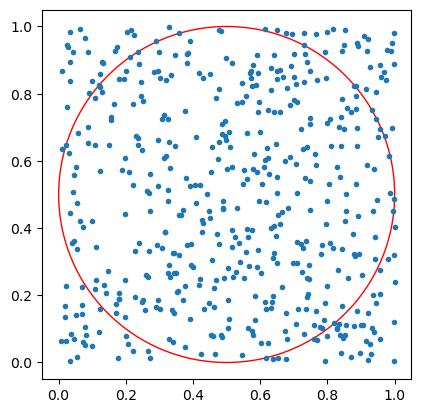

With our Monte Carlo method, we experimentally find pi = 3.12.


In [10]:
import random
import matplotlib.pyplot as plt

total = 500  # total number of samples

x = [random.uniform(0,1) for i in range(0, total)]   # x coordinate of our samples (x in [0,1])
y = [random.uniform(0,1) for i in range(0, total)]   # y coordinate of our samples (y in [0,1])

counter = 0                    # initialisation of our counter
for i in range(0,total):       # for each sample, we test
    if x[i]**2 + y[i]**2 < 1:  # if it lies in the unit circle
        counter += 1           # then we add 1 to the counter
        
print('On %s samples of the unit square, %s samples also lie in the unit disc.' %( total  , counter))


fig = plt.figure()        # we plot the samples, together with the unit circle
ax = fig.add_subplot(1, 1, 1)
circ = plt.Circle((0.5, 0.5), radius=0.5, edgecolor='r', facecolor='None')
ax.add_patch(circ)
plt.plot(x, y,  '.')
ax.set_aspect('equal', 'box')
plt.show()

pi = 4*counter/total      # we estimate pi

print('With our Monte Carlo method, we experimentally find pi = %s.' %(pi))

(Using probability in order to compute integrals or numbers is a pretty old idea: we can see similarities with the Buffon's needle problem (1733).)

*Please have fun with this little code: we can compute much harder integrals than a disc with the same technique! Example, take a map with a scale and evaluate the area of the Léman (Genfersee).*

## 4. Markov chain Monte Carlo: the Metropolis$-$Hastings algorithm  

In order to apply a Monte Carlo method, we then need to generate samples of the probability distribution function $P(x)$. A well-used technique consists in using a Markov chain: in this case we say that the method is a Markov chain Monte Carlo (MCMC) method.

A stochastic process is a *Markov chain* if it has the Markov property:

\begin{equation}
P(X_n = s_n | X_0 = s_0, X_1 = s_1, \cdots, X_{n-1} = s_{n-1}) = P(X_n = s_n | X_{n-1} = s_{n-1}) \, , \notag
\end{equation}

i.e. the $n$-th step of the process only depends on the $(n-1)$-th.

The Metropolis–Hastings (or often just “Metropolis”) algorithm (Nicholas Metropolis et al., 1950s, then generalised by Wilfred Hastings, 1970) is one of the most used MCMC method. It consists in [1, 2]:

   1) Start from a random point $x$;
   
   2) Propose a candidate point $y$, coming from a proposal distribution $J(x, y)$ ($J$ is a Markov matrix);
   
   3) Evaluate the posterior at the candidate point $y$: $\mathcal{P}(y)$, and accept $y$ with probability:
   
   \begin{equation}
        \alpha = \min \left (  \frac{\mathcal{P}(y) J(y, x)}{\mathcal{P}(x) J(x, y)}, 1 \right ) \, ; \notag
   \end{equation}
    
   4) If the candidate point $y$ is accepted, then we add it to the chain. Otherwise we add $x$ to the chain;
   
   5) Go back to 2).
   
   
Comments: points 3) and 4) are called the *Metropolis test* and $\alpha$ is the *Metropolis criteria*. About $\alpha$: very often (in the case of a "true" Metropolis algorithm), the Markov matrix $J$ is symmetric, so:

\begin{equation}
\alpha_\text{sym} = \min \left (  \frac{\mathcal{P}(y)}{\mathcal{P}(x)}, 1 \right ) \, , \notag
\end{equation}

and it means that if the probability of the new point $y$ is higher than the probability of the old point $x$, then $y$ must *always* be accepted. However, if the probability of $y$ is smaller than the one of $x$, $y$ must *sometimes* be accepted: this allows the chain to exit a local maximum.

**Convergence of the chains:** When sould we stop the algorithm? There isn't any precise mathematical answer to this question [4]. Indeed, we've seen that the convergence of the process is (almost surely) true for the infinite number of samples limit. 

It exists a few different statistical tests that must be filled in order to trust in the result. One of them uses the *autocorrelation time* $\tau$: it can be interpreted as being the number of steps that the chain needs to "forget" where it started [5]. Empirical tests show that a chain with a number of steps larger than $50 \tau$ can be trusted. Of course this limit is pretty arbitrary.

## 5. $\texttt{emcee}$ [5, 6]

$\texttt{emcee}$ is a Python package that is easy to use and that we're using in a few research projects. $\texttt{emcee}$ **does not use** a Metropolis$-$Hastings (MH) algorithm, but rather uses a "stretch move" ensemble method [6]. This algorithm is significantly better than MH (in the sense that is is faster, with a smaller autocorrelation time).

In the stretch move algorithm, there is an ensemble of $W$ walkers that evolve simultaneously. And the proposed position (as for step 2 of MH) of the walker $w$ for a time $n + 1$ depends on the positions of the $W − 1$ other walkers.

Explicitly, if we want to propose a new position for the walker $w$, whose position is $X_{w(n)}$, we randomly choose another walker $j$ ($j \neq w$) and we propose:

\begin{equation}
Y = X_j + Z [X_w(n) − X_j ] \, , \notag
\end{equation}

where $Z$ is a random variable drawn from a distribution $g(Z)$ and where $X_j$ is the position of the walker $j$ at the moment of the test (since $w$ and $j$ are randomly chosen, they are not necessarily at the same time).

At this step, a test is done (see step 3 of MH). We compute:

\begin{equation}
q = \min \left ( 1; Z^{n-1} \frac{\mathcal{P}(Y)}{\mathcal{P}(X_w(n))}   \right ) \, , \notag
\end{equation}

and we accept the proposed position $Y$ with probability $q$ (see step 4 of MH). Then we do this algorithm for each walker. And we start again.

**Example 4:** This example is taken from the official $\texttt{emcee}$ tutorial, see [5], with some simplifications and comments.

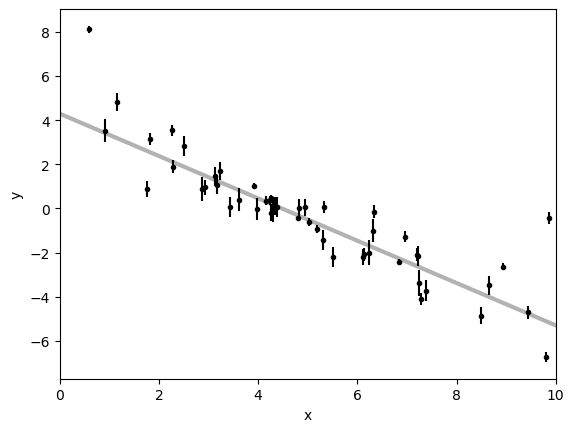

In [2]:
## Here we want to generate data from a theory T with free parameters m, b and f.

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

# Choose the fiducial value of the parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model. Here we add some random noise to the outputs to mimick real 
# experiment or observation data (in example 2, it was easier, we had no noise)
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

# plot the produced data and the model
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Now that we have produced data $\mathcal{D}$ from a theory $T$ with free parameters $\theta = (m, b, f)$. Our goal is now to use the software $\texttt{emcee}$ to constrain the value of $\theta$ given the data $\mathcal{D}$ (and the theory $T$).

$\texttt{emcee}$ works with the (natural) logarithmic version of eq. (3):

\begin{equation}
\ln p(\theta | \mathcal{D} ) \propto \ln \mathcal{L} ( \mathcal{D} | \theta ) + \ln \pi (\theta) \, , \tag{5}
\end{equation}

because the addition is easier than the multiplication to handle with (multiplication of small numbers will quickly reach your computer accuracy and give 0).

In [3]:
# definition of the *logarithm* of the likelihood: ln L(D | theta)
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [4]:
# definition of the *logarithm* of the prior: ln pi(theta)
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [5]:
# definition of the *logarithm* of the posterior: ln p(theta | D) = ln L(D | theta) + ln pi(theta)
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [6]:
# Here we do the MCMC
import emcee

totalsteps = 50000 # total number of steps, takes ~30 seconds on my laptop, you can change it

pos = np.random.randn(32, 3) # this are the first position of the walkers: randomly chosen
nwalkers, ndim = pos.shape # number of walker = 32, number of dimensions (= number of free parameters) = 3

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, totalsteps, progress=True);

  0%|                                                 | 0/50000 [00:00<?, ?it/s]/home/edwin/anaconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████| 50000/50000 [00:32<00:00, 1528.17it/s]


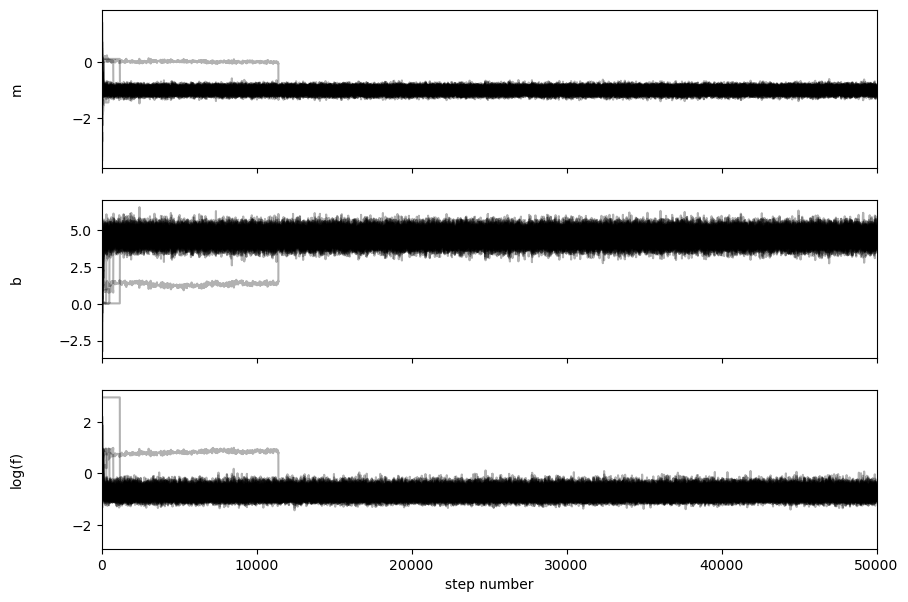

In [7]:
# Here we want to see the evolution of the chains that we've compute before: x-axis the number of steps, y-axis the 
# value of the chain at each step,this for each parameters (3) and each walker is plotted (32 walkers)
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [8]:
# Here we want to check the autocorrelation time. With 50 000 steps, it is probably too low to trust in the results 
# of the inference: have fun with trying a larger number of steps!
tau = sampler.get_autocorr_time()
print(tau)

[127.09666473 135.29587762 137.79454468]


In [9]:
# here we're doing two things: 1. we want to thin the chains (we only take the data every 15 steps to reduce the 
# quantity of data), 2. we discard the 100 first steps because the chains started from random values that we
# don´t care about
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(106432, 3)


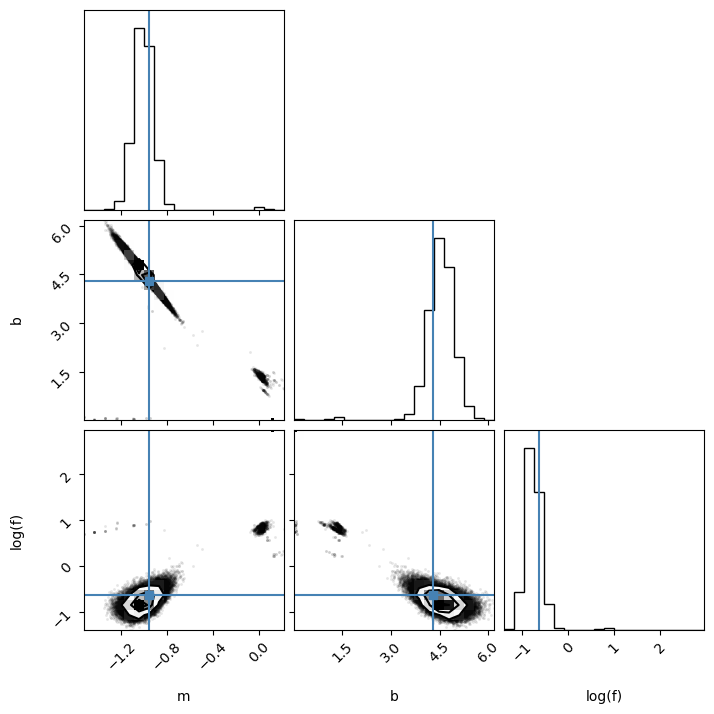

In [10]:
# Finally here we want to plot the results (again, the software will complain that it doesn't have enough points: 
# you can try to add more steps to the chains, but it could also mean that we do not have enough data to conclude.)

import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

**Comment on corner plots:** This plot is called a *corner plot*. It is the usual way to represent MCMC posteriors: when we have $p$ parameters to constrain, the posterior is a $p$-dimensional function. In a corner plot, on the diagonal, we plot the histograms (or sometimes the smoothed distributions) of a variable (i.e. the posterior marginalised over the other variables). Hence there are $p$ histograms of one variable to plot a function of $p$ variables.

Under the diagonal are shown the contour plots of two different variables. The contours highlight different *credible levels* (in Bayesian statistics we DO NOT talk about confidence levels but about *credible levels*!). All the 2-by-2 combinations of variables are plotted. We then have $(p − 1)p/2$ contour plots of two variables to plot a
function of $p$ variables.

## 6. Advanced topic: good scientific practice with $\texttt{emcee}$, see ref. [5]

To have a good practice with $\texttt{emcee}$, we must *always*: 

   1. save the chains in order for someone else to check your work from the raw data;
   2. stop the chains only when the (mean) autocorrelation time is smaller than the number of steps / 50 (or even 100);
   3. the discard and thin of the chains must depend on the autocorrelation time.
   
See below how we do it!

The following tutorial mostly comes from ref. [5], with some modifications (adaptation for our inference), and more comments.

**!! Be careful, the following cells take time to run, and the first one creates a new folder in your computer where you run this Jupyter notebook !!**

In [11]:
# First we create a file to save the data
# importing os module 
import os
  
# Directory
parent_dir = './' # where we want to create the 'results' directory
directoryname = 'MCMC_results/' # directory's name !!!! if this directory already exists then message error:
# then please use a different name or erase the previous folder
resultspath = os.path.join(parent_dir, directoryname)

os.mkdir(resultspath)
print("Directory '%s' is created" %directoryname)

Directory 'MCMC_results/' is created


From here on, we re-analyse the data $\mathcal{D}$ that we simulated in part 5. (1st cell), as well as the functions definitions in part 5. (cells 2, 3 & 4). 

In [12]:
# Point 1: we want to save the chains
# Point 2: we want to stop the chains after convergence

import emcee
max_n = 100000 # This number is the theoretical maximum number of steps, the MCMC stops earlier if convergence (see
# below the convergence test)

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.zeros(max_n)


pos = np.random.randn(32, 3) # this are the first position of the walkers: randomly chosen
nwalkers, ndim = pos.shape # number of walker = 32, number of dimensions (= number of free parameters) = 3



## We want to save the chains into a .h5 data file
# Set up the backend
# Don't forget to clear it in case the file already exists
chainsfilename = 'chains.h5' # name of the file !!!!! Be careful that this name is not already used in the 
# results folder!!!!!

backend = emcee.backends.HDFBackend(resultspath + chainsfilename)
backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr), backend=backend ### !!!! backend=backend saves the data
)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(pos, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence: we define convergence if the mean autocorrelation time times 100 is smaller than the total 
    # number of steps (1st line) AND if the mean autoccorelation time does not change a lot between two checks 
    # (2nd line). These numbers are those suggested in the emcee tutorial ref. [5].
    converged = np.all(tau * 100 < sampler.iteration) 
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

 28%|█████████▋                         | 27600/100000 [02:23<06:16, 192.52it/s]


NB: The chains file is pretty heavy, for 27600 steps, it weighs 217 Mo.

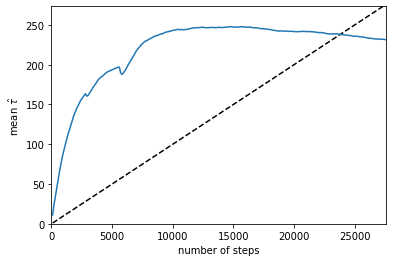

In [13]:
# Plot of the (mean) autocorrelation time as a function of the number of steps in the chains

import matplotlib.pyplot as plt

n = 100 * np.arange(1, index + 1)
y2 = autocorr[:index]
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y2)
plt.xlim(0, n.max())
plt.ylim(0, y2.max() + 0.1 * (y2.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");
plt.savefig(resultspath + 'tauhat_vs_nb_steps.pdf')

The blue line crosses the black dashed line: converged!

burn-in: 550
thin: 89
flat chain shape: (9696, 3)


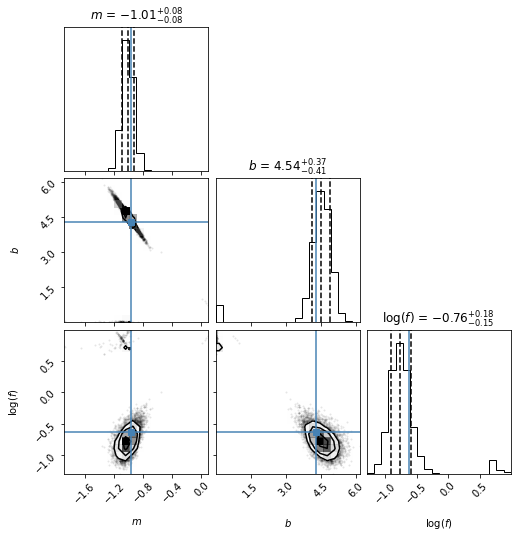

In [14]:
#Point 3: we want to use a good value of burnin and thin:

import corner
labels = [r"$m$", "$b$", "$\log(f)$"]

tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))

logf_true = np.log(f_true)
truths = [m_true, b_true, logf_true]

# Here we want to plot the results of the inference as a corner plot. We show the 16, 50 and 84% intervals, i.e.
# median value and 68% credibility interval (grey dashed lines) as well as the fiducial values (blue lines)

fig = corner.corner(samples, quantiles=(0.16, 0.5, 0.84), labels=labels, show_titles=True,
    title_kwargs={"fontsize": 12},truths=truths);
plt.savefig(resultspath + 'corner_plot_results.pdf')


If we want to read the .h5 data file and if we want to restart runs from the last step (it's a Markov chain, only the final step is relevant to start again the runs):

In [15]:
# Check if we can access the stored data, see ref. [5]

reader = emcee.backends.HDFBackend(resultspath + chainsfilename)

tau = reader.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))

burn-in: 550
thin: 89


In [16]:
# If we want to re-start a run, we use the following: (see: ref. [5])

new_backend = emcee.backends.HDFBackend(resultspath + chainsfilename)
print("Initial size: {0}".format(new_backend.iteration))
new_sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr), backend=new_backend, 
)
newsteps = 100 # number of new steps we want
new_sampler.run_mcmc(None, newsteps, progress=True) 
print("Final size: {0}".format(new_backend.iteration))


Initial size: 27600


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 273.83it/s]

Final size: 27700


## 7. References

**On Bayesian statistics and inference:**

[1] Trotta, Roberto. "Bayesian Methods in Cosmology". (Lecture notes for the 44th Saas Fee Advanced Course on Astronomy and Astrophysics.) [Submitted on 5 Jan 2017] https://arxiv.org/abs/1701.01467 [astro-ph.CO]. *[Amazing lecture notes! <3]*

**On Monte-Carlo and MCMC:**

[2] Diaconis, Persi. "The Markov chain Monte Carlo revolution". Bulletin of the American Mathematical Society, Volume 46, Number 2, April 2009, Pages 179–205. Available at: https://www.ams.org/journals/bull/2009-46-02/S0273-0979-08-01238-X/. *[Mathematical description of MCMC with proofs and definitions. Also a very nice introduction that shows how to use MCMC for cryptography... ;-)]*

[3] Krauth, Werner. *Statistical Mechanics: Algorithms and Computations*. Oxford Master Series in Statistical, Computational, and Theoretical Physics. Oxford University Press, Oxford, 2006. ISBN: 978-0-19-851535-7. *[Nice book with many examples, especially for statistical physics]*

[4] Sinharay, Sandip. "Assessing Convergence of the Markov Chain Monte Carlo Algorithms: A Review". Educational Testing Service, Princeton, NJ, March 2003. (Research Reports.) Available at: https://onlinelibrary.wiley.com/doi/epdf/10.1002/j.2333-8504.2003.tb01899.x. *[About the convergence of chains]*


**On $\texttt{emcee}$:**

[5] “emcee — emcee 3.0.2 documentation”. Online documentation of the Python package emcee. Available at: https://emcee.readthedocs.io/en/stable/#.

[6] Foreman-Mackey, Daniel; Hogg, David W.; Lang, Dustin & Goodman, Jonathan. "emcee: The MCMC Hammer". Publications of the Astronomical Society of the Pacific, Volume 125, Number 925, 25 February 2013. https://arxiv.org/abs/1202.3665v4 [astro-ph.IM]


**I've also used my master's thesis and the references therein:**

[7] Genoud-Prachex, Edwin. "Constraining modified gravitational wave propagation with the black hole mass gap", master's thesis, University of Geneva, 2021. Available on: https://dmgw.space/pdfs/thesis/master_thesis_edwin_genoudprachex.pdf